In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
# import pathlib"
# AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
tf.keras.backend.clear_session()
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [2]:
# def read_image(path, size):
#     img_raw = tf.io.read_file(path)
#     img_tensor = tf.image.decode_image(img_raw)
#     img_final = tf.image.resize(img_tensor, [size, size])
#     img_final = img_final/255.0
#     img_final = img_final.astype(np.float32)
    
#     return img_final
def read_image(path, size):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (size, size))
    image = image / 255.0
    image = image.astype(np.float32)
    return image

def parse_data(x, y):
    x = x.decode()

    num_class = 120
    size = 224

    image = read_image(x, size)
    label = [0] * num_class
    label[y] = 1
    label = np.array(label)
    label = label.astype(np.int32)

    return image, label

def tf_parse(x, y):
    x, y = tf.numpy_function(parse_data, [x, y], [tf.float32, tf.int32])
    x.set_shape((224, 224, 3))
    y.set_shape((120))
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [3]:
path = "./data"
train_path = os.path.join(path, "train/*")
test_path = os.path.join(path, "test/*")
labels_path = os.path.join(path, "labels.csv")

labels_df = pd.read_csv(labels_path)
breed = labels_df["breed"].unique()
print("Number of Breed: ", len(breed))
breed = sorted(breed)
breed2id = {name: i for i, name in enumerate(breed)}
# breed2id = dict(sorted(breed2id.items(), key=lambda k: k[0]))
ids = glob(train_path)
labels = []

for image_id in ids:
    image_id = image_id.split("\\")[-1].split(".")[0]
    breed_name = list(labels_df[labels_df.id == image_id]["breed"])[0]
    breed_idx = breed2id[breed_name]
    labels.append(breed_idx)

## Spliting the dataset
train_x, valid_x = train_test_split(ids, test_size=0.2, random_state=16)
train_y, valid_y = train_test_split(labels, test_size=0.2, random_state=16)

Number of Breed:  120


In [6]:
def MNV2_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = MobileNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [7]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 48
epochs = 50

## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = MNV2_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("MNV2_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit1 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [43]:
history = []
history1 = []
history1.append(history_fit1.history['loss'])
history1.append(history_fit1.history['val_loss'])
history1.append(history_fit1.history['accuracy'])
history1.append(history_fit1.history['val_accuracy'])
history.append(history1)
history1 = np.array(history1)
np.save("history1.npy",history1)
tf.keras.backend.clear_session()

In [38]:
def Xception_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = Xception(input_tensor=inputs, input_shape = (size, size, 3), include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [39]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 50

## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = Xception_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("Xception_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit2 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/50
256/256 [==============================] - 32s 118ms/step - loss: 1.9831 - accuracy: 0.4997 - val_loss: 1.2494 - val_accuracy: 0.6401

Epoch 00001: val_loss improved from inf to 1.24939, saving model to Xception_model.h5
Epoch 2/50
256/256 [==============================] - 29s 113ms/step - loss: 1.1814 - accuracy: 0.6535 - val_loss: 1.1669 - val_accuracy: 0.6606

Epoch 00002: val_loss improved from 1.24939 to 1.16690, saving model to Xception_model.h5
Epoch 3/50
256/256 [==============================] - 30s 115ms/step - loss: 0.9563 - accuracy: 0.7103 - val_loss: 1.1517 - val_accuracy: 0.6719

Epoch 00003: val_loss improved from 1.16690 to 1.15166, saving model to Xception_model.h5
Epoch 4/50
256/256 [==============================] - 29s 114ms/step - loss: 0.8220 - accuracy: 0.7491 - val_loss: 1.1850 - val_accuracy: 0.6758

Epoch 00004: val_loss did not improve from 1.15166
Epoch 5/50
256/256 [==============================] - 29s 113ms/step - loss: 0.6932 - accuracy: 0.7

In [40]:
history2 = []
history2.append(history_fit2.history['loss'])
history2.append(history_fit2.history['val_loss'])
history2.append(history_fit2.history['accuracy'])
history2.append(history_fit2.history['val_accuracy'])
# history.append(history2)
history2 = np.array(history2)
np.save("history2.npy",history2)
tf.keras.backend.clear_session()

In [6]:
def ResNet152V2_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = ResNet152V2(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [61]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 50
## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = ResNet152V2_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("ResNet152V2_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit3 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/50
256/256 [==============================] - 60s 212ms/step - loss: 2.2257 - accuracy: 0.4480 - val_loss: 1.4208 - val_accuracy: 0.6015

Epoch 00001: val_loss improved from inf to 1.42084, saving model to ResNet152V2_model.h5
Epoch 2/50
256/256 [==============================] - 54s 209ms/step - loss: 1.2645 - accuracy: 0.6383 - val_loss: 1.2776 - val_accuracy: 0.6445

Epoch 00002: val_loss improved from 1.42084 to 1.27763, saving model to ResNet152V2_model.h5
Epoch 3/50
256/256 [==============================] - 54s 209ms/step - loss: 0.9809 - accuracy: 0.7094 - val_loss: 1.2733 - val_accuracy: 0.6465

Epoch 00003: val_loss improved from 1.27763 to 1.27327, saving model to ResNet152V2_model.h5
Epoch 4/50
256/256 [==============================] - 54s 210ms/step - loss: 0.8075 - accuracy: 0.7449 - val_loss: 1.3401 - val_accuracy: 0.6499

Epoch 00004: val_loss did not improve from 1.27327
Epoch 5/50
256/256 [==============================] - 54s 209ms/step - loss: 0.6560 - accu


Epoch 00041: val_loss did not improve from 1.27066
Epoch 42/50
256/256 [==============================] - 55s 213ms/step - loss: 0.1012 - accuracy: 0.9677 - val_loss: 1.2942 - val_accuracy: 0.7100

Epoch 00042: val_loss did not improve from 1.27066
Epoch 43/50
256/256 [==============================] - 54s 211ms/step - loss: 0.1051 - accuracy: 0.9645 - val_loss: 1.2944 - val_accuracy: 0.7105

Epoch 00043: val_loss did not improve from 1.27066
Epoch 44/50
256/256 [==============================] - 55s 213ms/step - loss: 0.1109 - accuracy: 0.9617 - val_loss: 1.2940 - val_accuracy: 0.7090

Epoch 00044: val_loss did not improve from 1.27066
Epoch 45/50
256/256 [==============================] - 56s 217ms/step - loss: 0.1060 - accuracy: 0.9648 - val_loss: 1.2941 - val_accuracy: 0.7100

Epoch 00045: val_loss did not improve from 1.27066
Epoch 46/50
256/256 [==============================] - 56s 217ms/step - loss: 0.1036 - accuracy: 0.9666 - val_loss: 1.2942 - val_accuracy: 0.7095

Epoch 000

In [65]:
history3 = []
history3.append(history_fit3.history['loss'])
history3.append(history_fit3.history['val_loss'])
history3.append(history_fit3.history['accuracy'])
history3.append(history_fit3.history['val_accuracy'])
# history.append(history3)
history3 = np.array(history3)
np.save("history3.npy",history3)
tf.keras.backend.clear_session()

In [59]:
def ResNeXt101_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = tf.keras.applications.ResNet101(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="tanh")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [60]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 50

## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = ResNeXt101_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("ResNeXt101_model.h5", verbose=1, save_best_only=True),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit4 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/50
256/256 [==============================] - 58s 205ms/step - loss: 4.8289 - accuracy: 0.0107 - val_loss: 4.7612 - val_accuracy: 0.0187

Epoch 00001: val_loss improved from inf to 4.76120, saving model to ResNeXt101_model.h5
Epoch 2/50
256/256 [==============================] - 53s 205ms/step - loss: 4.7361 - accuracy: 0.0171 - val_loss: 4.7099 - val_accuracy: 0.0200

Epoch 00002: val_loss improved from 4.76120 to 4.70992, saving model to ResNeXt101_model.h5
Epoch 3/50
256/256 [==============================] - 53s 209ms/step - loss: 4.7092 - accuracy: 0.0195 - val_loss: 4.7001 - val_accuracy: 0.0151

Epoch 00003: val_loss improved from 4.70992 to 4.70005, saving model to ResNeXt101_model.h5
Epoch 4/50
256/256 [==============================] - 54s 210ms/step - loss: 4.6939 - accuracy: 0.0188 - val_loss: 4.6947 - val_accuracy: 0.0170

Epoch 00004: val_loss improved from 4.70005 to 4.69466, saving model to ResNeXt101_model.h5
Epoch 5/50
256/256 [==============================] 

In [64]:
history4 = []
history4.append(history_fit4.history['loss'])
history4.append(history_fit4.history['val_loss'])
history4.append(history_fit4.history['accuracy'])
history4.append(history_fit4.history['val_accuracy'])
# history.append(history4)
history4 = np.array(history4)
np.save("history4.npy",history4)
tf.keras.backend.clear_session()

In [4]:
def NASNet_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = NASNetLarge(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [5]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 50

## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = NASNet_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("NASNet_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit5 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/50
256/256 [==============================] - 101s 324ms/step - loss: 1.6971 - accuracy: 0.5879 - val_loss: 1.2354 - val_accuracy: 0.6548

Epoch 00001: val_loss improved from inf to 1.23540, saving model to NASNet_model.h5


G:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
256/256 [==============================] - 78s 306ms/step - loss: 1.0467 - accuracy: 0.7026 - val_loss: 1.2069 - val_accuracy: 0.6792

Epoch 00002: val_loss improved from 1.23540 to 1.20687, saving model to NASNet_model.h5
Epoch 3/50
256/256 [==============================] - 79s 307ms/step - loss: 0.8072 - accuracy: 0.7559 - val_loss: 1.2425 - val_accuracy: 0.6836

Epoch 00003: val_loss did not improve from 1.20687
Epoch 4/50
256/256 [==============================] - 79s 308ms/step - loss: 0.6831 - accuracy: 0.7933 - val_loss: 1.2371 - val_accuracy: 0.6910

Epoch 00004: val_loss did not improve from 1.20687
Epoch 5/50
256/256 [==============================] - 79s 309ms/step - loss: 0.5691 - accuracy: 0.8194 - val_loss: 1.3317 - val_accuracy: 0.6778

Epoch 00005: val_loss did not improve from 1.20687
Epoch 6/50
256/256 [==============================] - 79s 308ms/step - loss: 0.5079 - accuracy: 0.8315 - val_loss: 1.3365 - val_accuracy: 0.6963

Epoch 00006: val_loss did not

256/256 [==============================] - 86s 338ms/step - loss: 0.1181 - accuracy: 0.9579 - val_loss: 1.2681 - val_accuracy: 0.7291

Epoch 00043: val_loss did not improve from 1.18928
Epoch 44/50
256/256 [==============================] - 86s 336ms/step - loss: 0.1185 - accuracy: 0.9631 - val_loss: 1.2683 - val_accuracy: 0.7291

Epoch 00044: val_loss did not improve from 1.18928
Epoch 45/50
256/256 [==============================] - 86s 336ms/step - loss: 0.1134 - accuracy: 0.9656 - val_loss: 1.2688 - val_accuracy: 0.7291

Epoch 00045: val_loss did not improve from 1.18928
Epoch 46/50
256/256 [==============================] - 86s 337ms/step - loss: 0.1221 - accuracy: 0.9579 - val_loss: 1.2690 - val_accuracy: 0.7281

Epoch 00046: val_loss did not improve from 1.18928
Epoch 47/50
256/256 [==============================] - 87s 339ms/step - loss: 0.1191 - accuracy: 0.9599 - val_loss: 1.2693 - val_accuracy: 0.7281

Epoch 00047: val_loss did not improve from 1.18928
Epoch 48/50
256/256 [=

In [34]:
history5 = []
history5.append(history_fit5.history['loss'])
history5.append(history_fit5.history['val_loss'])
history5.append(history_fit5.history['accuracy'])
history5.append(history_fit5.history['val_accuracy'])
# history.append(history5)
history5 = np.array(history5)
np.save("history5.npy",history5)
tf.keras.backend.clear_session()

In [18]:
def InceptionResNetV2_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = InceptionResNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [4]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 5000

## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = InceptionResNetV2_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("InceptionResNetV2_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit6 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

NameError: name 'InceptionResNetV2_model' is not defined

In [37]:
history6 = []
history6.append(history_fit6.history['loss'])
history6.append(history_fit6.history['val_loss'])
history6.append(history_fit6.history['accuracy'])
history6.append(history_fit6.history['val_accuracy'])
# history.append(history6)
history6 = np.array(history6)
np.save("history6.npy",history6)
tf.keras.backend.clear_session()

In [69]:
tf.keras.backend.clear_session()
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [4]:
def Fine_tune_NASNet(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = NASNetLarge(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
#     x = Dense(512, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = Dense(256, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [ ]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 3000

## Dataset
train_dataset = tf_dataset(ids, labels, batch=batch)
# valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
# model = tf.keras.models.load_model('Fine_tune_NASNet_model.h5')
model = Fine_tune_NASNet(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("Fine_tune_NASNet_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-10)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit7 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=train_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/3000
256/256 [==============================] - 81s 261ms/step - loss: 1.7233 - accuracy: 0.5837 - val_loss: 1.0477 - val_accuracy: 0.7100

Epoch 00001: val_loss improved from inf to 1.04770, saving model to Fine_tune_NASNet_model.h5


D:\Anaconda_data\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/3000
256/256 [==============================] - 63s 247ms/step - loss: 1.1579 - accuracy: 0.6809 - val_loss: 0.8080 - val_accuracy: 0.7563

Epoch 00002: val_loss improved from 1.04770 to 0.80798, saving model to Fine_tune_NASNet_model.h5
Epoch 3/3000
256/256 [==============================] - 63s 247ms/step - loss: 0.9939 - accuracy: 0.7094 - val_loss: 0.6080 - val_accuracy: 0.8027loss: 0.9946 - accuracy: 0.

Epoch 00003: val_loss improved from 0.80798 to 0.60796, saving model to Fine_tune_NASNet_model.h5
Epoch 4/3000
256/256 [==============================] - 63s 247ms/step - loss: 0.8497 - accuracy: 0.7472 - val_loss: 0.3925 - val_accuracy: 0.8804

Epoch 00004: val_loss improved from 0.60796 to 0.39254, saving model to Fine_tune_NASNet_model.h5
Epoch 5/3000
 15/256 [>.............................] - ETA: 49s - loss: 0.6753 - accuracy: 0.7792

In [ ]:
history7 = []
history7.append(history_fit7.history['loss'])
history7.append(history_fit7.history['val_loss'])
history7.append(history_fit7.history['accuracy'])
history7.append(history_fit7.history['val_accuracy'])
# history.append(history6)
history7 = np.array(history7)
np.save("history7.npy",history7)
tf.keras.backend.clear_session()

In [8]:
def DenseNet201_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = DenseNet201(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [9]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 50

## Dataset
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
model = DenseNet201_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("DenseNet201_model_model.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit8 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/50
256/256 [==============================] - 48s 148ms/step - loss: 2.6205 - accuracy: 0.3456 - val_loss: 1.4126 - val_accuracy: 0.6005

Epoch 00001: val_loss improved from inf to 1.41264, saving model to DenseNet201_model_model.h5
Epoch 2/50
256/256 [==============================] - 33s 127ms/step - loss: 1.4061 - accuracy: 0.5848 - val_loss: 1.2223 - val_accuracy: 0.6396

Epoch 00002: val_loss improved from 1.41264 to 1.22228, saving model to DenseNet201_model_model.h5
Epoch 3/50
256/256 [==============================] - 33s 127ms/step - loss: 1.1564 - accuracy: 0.6523 - val_loss: 1.1997 - val_accuracy: 0.6582

Epoch 00003: val_loss improved from 1.22228 to 1.19972, saving model to DenseNet201_model_model.h5
Epoch 4/50
256/256 [==============================] - 33s 128ms/step - loss: 0.9762 - accuracy: 0.6968 - val_loss: 1.1551 - val_accuracy: 0.6709

Epoch 00004: val_loss improved from 1.19972 to 1.15510, saving model to DenseNet201_model_model.h5
Epoch 5/50
256/256 [====

In [20]:
history8 = []
history8.append(history_fit8.history['loss'])
history8.append(history_fit8.history['val_loss'])
history8.append(history_fit8.history['accuracy'])
history8.append(history_fit8.history['val_accuracy'])
# history.append(history6)
history8 = np.array(history8)
np.save("history8.npy",history8)
tf.keras.backend.clear_session()

In [15]:
def Fine_tune_DenseNet201_model(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = DenseNet201(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [17]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 100

## Dataset
train_dataset = tf_dataset(ids, labels, batch=batch)
# valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
# model = tf.keras.models.load_model('Fine_tune_InceptionResNetV2.h5')
model = Fine_tune_DenseNet201_model(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("Fine_tune_DenseNet201.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit7 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=train_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/100
256/256 [==============================] - 42s 135ms/step - loss: 2.7493 - accuracy: 0.3262 - val_loss: 1.2445 - val_accuracy: 0.6538

Epoch 00001: val_loss improved from inf to 1.24450, saving model to Fine_tune_DenseNet201.h5
Epoch 2/100
256/256 [==============================] - 34s 133ms/step - loss: 1.5414 - accuracy: 0.5554 - val_loss: 0.9060 - val_accuracy: 0.7300

Epoch 00002: val_loss improved from 1.24450 to 0.90596, saving model to Fine_tune_DenseNet201.h5
Epoch 3/100
256/256 [==============================] - 32s 125ms/step - loss: 1.2813 - accuracy: 0.6115 - val_loss: 0.6883 - val_accuracy: 0.7886

Epoch 00003: val_loss improved from 0.90596 to 0.68831, saving model to Fine_tune_DenseNet201.h5
Epoch 4/100
256/256 [==============================] - 32s 126ms/step - loss: 1.1620 - accuracy: 0.6488 - val_loss: 0.5425 - val_accuracy: 0.8418

Epoch 00004: val_loss improved from 0.68831 to 0.54246, saving model to Fine_tune_DenseNet201.h5
Epoch 5/100
256/256 [=======

256/256 [==============================] - 33s 127ms/step - loss: 0.3926 - accuracy: 0.8702 - val_loss: 0.0416 - val_accuracy: 0.9922

Epoch 00039: val_loss improved from 0.04290 to 0.04162, saving model to Fine_tune_DenseNet201.h5
Epoch 40/100
256/256 [==============================] - 32s 127ms/step - loss: 0.3963 - accuracy: 0.8736 - val_loss: 0.0650 - val_accuracy: 0.9834

Epoch 00040: val_loss did not improve from 0.04162
Epoch 41/100
256/256 [==============================] - 33s 127ms/step - loss: 0.3993 - accuracy: 0.8713 - val_loss: 0.0625 - val_accuracy: 0.9854

Epoch 00041: val_loss did not improve from 0.04162
Epoch 42/100
256/256 [==============================] - 33s 127ms/step - loss: 0.3755 - accuracy: 0.8794 - val_loss: 0.0674 - val_accuracy: 0.9824

Epoch 00042: val_loss did not improve from 0.04162
Epoch 43/100
256/256 [==============================] - 33s 127ms/step - loss: 0.3772 - accuracy: 0.8777 - val_loss: 0.0479 - val_accuracy: 0.9883

Epoch 00043: val_loss d

Epoch 78/100
256/256 [==============================] - 33s 128ms/step - loss: 0.1692 - accuracy: 0.9440 - val_loss: 0.0042 - val_accuracy: 0.9995

Epoch 00078: val_loss improved from 0.00473 to 0.00425, saving model to Fine_tune_DenseNet201.h5
Epoch 79/100
256/256 [==============================] - 33s 127ms/step - loss: 0.1718 - accuracy: 0.9430 - val_loss: 0.0038 - val_accuracy: 0.9995

Epoch 00079: val_loss improved from 0.00425 to 0.00380, saving model to Fine_tune_DenseNet201.h5
Epoch 80/100
256/256 [==============================] - 32s 127ms/step - loss: 0.1738 - accuracy: 0.9465 - val_loss: 0.0035 - val_accuracy: 0.9995

Epoch 00080: val_loss improved from 0.00380 to 0.00347, saving model to Fine_tune_DenseNet201.h5
Epoch 81/100
256/256 [==============================] - 33s 127ms/step - loss: 0.1812 - accuracy: 0.9437 - val_loss: 0.0034 - val_accuracy: 0.9995

Epoch 00081: val_loss improved from 0.00347 to 0.00342, saving model to Fine_tune_DenseNet201.h5
Epoch 82/100
256/256

In [4]:
def Fine_tune_InceptionResNetV2(size, num_classes):
    inputs = Input((size, size, 3))
    backbone = InceptionResNetV2(input_tensor=inputs, include_top=False, weights="imagenet")
    backbone.trainable = False
    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation="relu")(x)
#     x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
#     x = Dense(512, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
#     x = Dense(256, activation="relu")(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, x)
    
    return model

In [11]:
## Parameters
size = 224
num_classes = 120
lr = 1e-4
batch = 32
epochs = 10

## Dataset
train_dataset = tf_dataset(ids, labels, batch=batch)
# valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

## Model
# model = tf.keras.models.load_model('Fine_tune_InceptionResNetV2.h5')
model = Fine_tune_InceptionResNetV2(size, num_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()


## Training
callbacks = [
    ModelCheckpoint("Fine_tune_InceptionResNetV2.h5", verbose=1, save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]
train_steps = (len(train_x)//batch) + 1
valid_steps = (len(valid_x)//batch) + 1
history_fit7 = model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    validation_data=train_dataset,
    epochs=epochs,
    callbacks=callbacks)

Epoch 1/10
256/256 [==============================] - 43s 141ms/step - loss: 1.8463 - accuracy: 0.5593 - val_loss: 1.0938 - val_accuracy: 0.6836

Epoch 00001: val_loss improved from inf to 1.09377, saving model to Fine_tune_InceptionResNetV2.h5
Epoch 2/10
256/256 [==============================] - 34s 135ms/step - loss: 1.2450 - accuracy: 0.6631 - val_loss: 1.0062 - val_accuracy: 0.7085

Epoch 00002: val_loss improved from 1.09377 to 1.00619, saving model to Fine_tune_InceptionResNetV2.h5
Epoch 3/10
256/256 [==============================] - 35s 137ms/step - loss: 1.1256 - accuracy: 0.6817 - val_loss: 0.8573 - val_accuracy: 0.7324

Epoch 00003: val_loss improved from 1.00619 to 0.85731, saving model to Fine_tune_InceptionResNetV2.h5
Epoch 4/10
256/256 [==============================] - 35s 136ms/step - loss: 1.0441 - accuracy: 0.6992 - val_loss: 0.6746 - val_accuracy: 0.7847

Epoch 00004: val_loss improved from 0.85731 to 0.67464, saving model to Fine_tune_InceptionResNetV2.h5
Epoch 5/

In [27]:
# MobileNetV2
history1 = np.load("history1.npy")
# Xception
history2 = np.load("history2.npy")
# ResNet152V2
history3 = np.load("history3.npy")
# NASNet
history5 = np.load("history5.npy")
# InceptionResNetV2
history6 = np.load("history6.npy")
# DenseNet201
history8 = np.load("history8.npy")

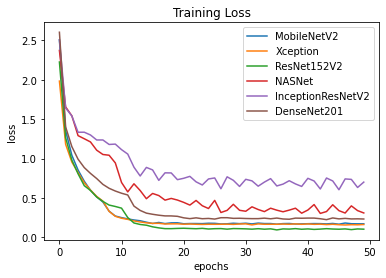

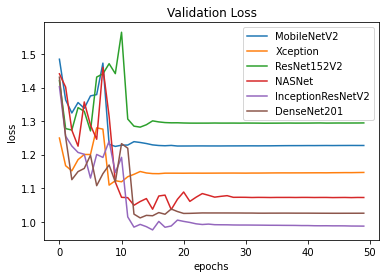

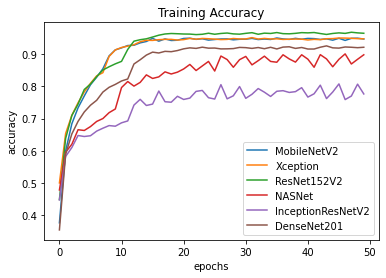

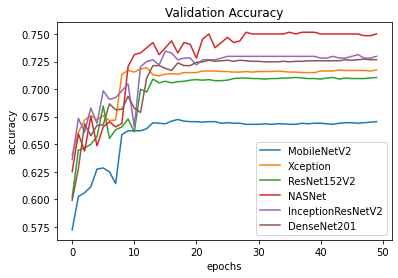

In [32]:
 #Plot train/validation loss vs epoch

#Plot loss vs epoch

plt.figure()
plt.title('Training Loss') 
plt.plot(history1[0])
plt.plot(history2[0])
plt.plot(history3[0])
plt.plot(history5[0])
plt.plot(history6[0])
plt.plot(history8[0])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['MobileNetV2', 'Xception','ResNet152V2','NASNet','InceptionResNetV2','DenseNet201'])
plt.show()
plt.figure()
plt.title('Validation Loss') 
plt.plot(history1[1])
plt.plot(history2[1])
plt.plot(history3[1])
plt.plot(history5[1])
plt.plot(history6[1])
plt.plot(history8[1])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['MobileNetV2', 'Xception','ResNet152V2','NASNet','InceptionResNetV2','DenseNet201'])
plt.show()
#Plot accuracy vs epoch

plt.figure()

plt.title('Training Accuracy') 
plt.plot(history1[2])
plt.plot(history2[2])
plt.plot(history3[2])
plt.plot(history5[2])
plt.plot(history6[2])
plt.plot(history8[2])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['MobileNetV2', 'Xception','ResNet152V2','NASNet','InceptionResNetV2','DenseNet201'])
plt.show()
plt.figure()
plt.title('Validation Accuracy') 
plt.plot(history1[3])
plt.plot(history2[3])
plt.plot(history3[3])
plt.plot(history5[3])
plt.plot(history6[3])
plt.plot(history8[3])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['MobileNetV2', 'Xception','ResNet152V2','NASNet','InceptionResNetV2','DenseNet201'])

plt.show()

In [27]:
tf.keras.backend.clear_session()
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [7]:
test_ids = glob(test_path)
image_ids = []
for img_id in test_ids:
    image_ids.append(img_id.split("\\")[-1].split(".")[0])

In [13]:
df_subm1 = pd.DataFrame(columns=breed2id.keys(),index=image_ids)
final_model1 = tf.keras.models.load_model('Fine_tune_NASNet_model.h5')
for i,t_id in enumerate(test_ids):
    image = read_image(t_id, 224)
    image = np.expand_dims(image, axis=0)
    pred = final_model1.predict(image)
    df_subm1.iloc[i] = pred
df_subm1.to_csv('submission1.csv')

In [12]:
df_subm2 = pd.DataFrame(columns=breed2id.keys(),index=image_ids)
final_model2 = tf.keras.models.load_model('Fine_tune_InceptionResNetV2.h5')
for i,t_id in enumerate(test_ids):
    image = read_image(t_id, 224)
    image = np.expand_dims(image, axis=0)
    pred = final_model2.predict(image)
    df_subm2.iloc[i] = pred
df_subm2.to_csv('submission2.csv')

In [20]:
df_subm3 = pd.DataFrame(columns=breed2id.keys(),index=image_ids)
final_model3 = tf.keras.models.load_model('Fine_tune_DenseNet201.h5')
for i,t_id in enumerate(test_ids):
    image = read_image(t_id, 224)
    image = np.expand_dims(image, axis=0)
    pred = final_model3.predict(image)
    df_subm3.iloc[i] = pred
df_subm3.to_csv('submission3.csv')

In [21]:
df_subm4 = pd.DataFrame(columns=breed2id.keys(),index=image_ids)
final_model4 = tf.keras.models.load_model('InceptionResNetV2_model.h5')
for i,t_id in enumerate(test_ids):
    image = read_image(t_id, 224)
    image = np.expand_dims(image, axis=0)
    pred = final_model4.predict(image)
    df_subm4.iloc[i] = pred
df_subm4.to_csv('submission4.csv')

In [11]:
df_subm5 = pd.DataFrame(columns=breed2id.keys(),index=image_ids)
final_model5 = tf.keras.models.load_model('NASNet_model.h5')
for i,t_id in enumerate(test_ids):
    image = read_image(t_id, 224)
    image = np.expand_dims(image, axis=0)
    pred = final_model5.predict(image)
    df_subm5.iloc[i] = pred
df_subm5.to_csv('submission5.csv')

In [12]:
df_subm6 = pd.DataFrame(columns=breed2id.keys(),index=image_ids)
final_model6 = tf.keras.models.load_model('DenseNet201_model_model.h5')
for i,t_id in enumerate(test_ids):
    image = read_image(t_id, 224)
    image = np.expand_dims(image, axis=0)
    pred = final_model6.predict(image)
    df_subm6.iloc[i] = pred
df_subm6.to_csv('submission6.csv')